## What should be presented in the case study:

#### 1. Degree (strength) distribution


#### 2. Two of the following characteristics:

    2.1 Average path length

    2.2 Clustering coefficient

    2.3 Small-worldness


 #### 3. At least one of centrality measures: 

    3.1 Degree centrality￼

    3.2 Closeness centrality￼

    3.3 Betweenness

    3.4 Prestige

    3.5 Decay centrality

#### 4. You need to consider at least 2 networks

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from scipy.stats import kstest, powerlaw
from functools import partial

# Data loading

In [2]:
path = "./data/"
fileName2019 = "EU_routes_2019.csv.gz"
fileName2022 = "EU_routes_2022.csv.gz"
fileAirports = "airports_clean.csv"
routes2019 = pd.read_csv(path + fileName2019)
routes2022 = pd.read_csv(path + fileName2022)
airports = pd.read_csv(path+fileAirports)
routes = {"2019": routes2019, "2022": routes2022}
years = ["2019", "2022"]

# Data exploration

In [3]:
# Number of unique origin_IATA_IATAs
for year in years:
    print(f"{year}: {routes[year].origin_IATA.nunique():3} origins and {routes[year].destination_IATA.nunique():3} destinations with {routes[year].weight.count()} total connections")

2019: 368 origins and 405 destinations with 7952 total connections
2022: 489 origins and 527 destinations with 13369 total connections


In [4]:
routes2022.head()

,origin_IATA,destination_IATA,weight,rec_aircrafts,rec_days,origin_airport_name,origin_city,origin_country,origin_ICAO,origin_latitude,origin_longitude,origin_continent,destination_airport_name,destination_city,destination_country,destination_ICAO,destination_latitude,destination_longitude,destination_continent
0,AAH,BNJ,4,4,6,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Bonn-Hangelar Airport,Sankt-Augustin,Germany,EDKB,50.768890,7.163333,EU
1,AAH,CGN,2,2,5,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Cologne Bonn Airport,Cologne,Germany,EDDK,50.865900,7.142740,EU
2,AAH,ESS,2,2,2,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Essen Mulheim Airport,Essen,Germany,EDLE,51.402300,6.937330,EU
3,AAH,FMO,2,2,2,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Münster Osnabrück Airport,Munster,Germany,EDDG,52.134600,7.684830,EU
4,AAH,MGL,3,3,3,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Mönchengladbach Airport,Moenchengladbach,Germany,EDLN,51.230278,6.504444,EU


In [5]:
routes2022.shape

(13369, 19)

# Basic Network Metrics and Plots

In [6]:
#create directed and undirected network object 
G2019_directed=nx.from_pandas_edgelist(routes2019, source = 'origin_IATA', target = 'destination_IATA', edge_attr= 'weight', create_using=nx.DiGraph())
G2019_undirected = nx.from_pandas_edgelist(routes2022, source = "origin_IATA", target = "destination_IATA", edge_attr= 'weight', create_using=nx.Graph())
G2022_directed=nx.from_pandas_edgelist(routes2022, source = 'origin_IATA', target = 'destination_IATA', edge_attr= 'weight', create_using=nx.DiGraph())
G2022_undirected = nx.from_pandas_edgelist(routes2022, source = "origin_IATA", target = "destination_IATA", edge_attr= 'weight', create_using=nx.Graph())
G_directed = {"2019": G2019_directed, "2022": G2022_directed}
G_undirected = {"2019": G2019_undirected, "2022": G2022_undirected}

In [7]:
# Returns the biggest giant strongly connected component in the network
G2019_directed_connected = G2019_directed.subgraph(sorted(nx.strongly_connected_components(G2019_directed), key = len, reverse = True)[0])
G2022_directed_connected = G2022_directed.subgraph(sorted(nx.strongly_connected_components(G2022_directed), key = len, reverse = True)[0])
G_directed_connected = {"2019": G2019_directed_connected, "2022": G2022_directed_connected}

In [8]:
#Produce adjecancy matrices for 2022 and 2022 for the directed network
adj2019 = nx.to_pandas_adjacency(G2019_directed, dtype = int)
adj2022 = nx.to_pandas_adjacency(G2022_directed, dtype = int)
adj2019.head()

,AAL,AAR,AGP,AMS,BRE,CPH,GOT,LEY,ODE,OSL,...,SPM,SQQ,ODH,KDL,LME,URE,WVN,AGE,XCR,KOQ
AAL,0,2,1,3,2,28,2,1,2,2,...,0,0,0,0,0,0,0,0,0,0
AAR,0,0,0,3,0,13,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
AGP,1,0,0,9,2,8,3,0,0,3,...,0,0,0,0,0,0,0,0,0,0
AMS,4,0,8,0,4,19,5,0,0,9,...,0,0,0,0,0,0,0,0,0,0
BRE,0,0,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


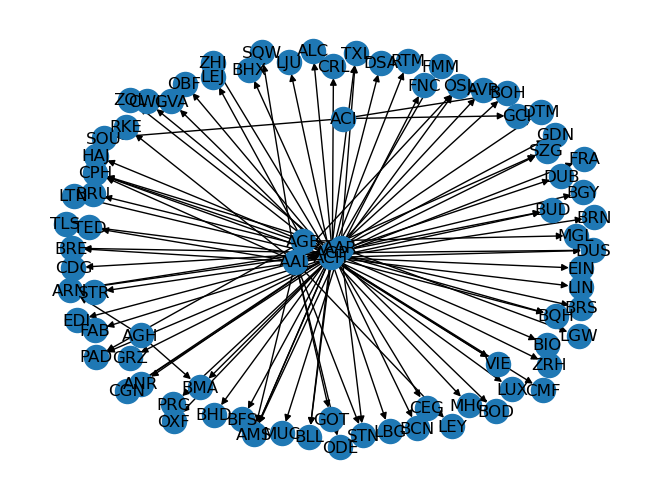

In [55]:
#draw a sample of the first 100 routes (Airports are Sorted by Origin, thus the central shape of some)
G_sample = nx.from_pandas_edgelist(routes2019[0:100], source = 'origin_IATA', target = 'destination_IATA', create_using=nx.DiGraph())
nx.draw(G_sample, with_labels = True)

In [25]:
#nx.draw(G2022_directed)

## Degree

In [9]:
#caluculate in degrees 
in_degree2019 = dict(G2019_directed.in_degree)
#out degree
out_degree2019 = dict(G2019_directed.out_degree)

In [11]:
G2022_directed.out_degree["BER"]

128

In [29]:
#calculate in-degree for each node using adjacency matrix (sum over rows)
#np.sum(adj2019, axis=0)
#np.sum(adj2022, axis = 1)

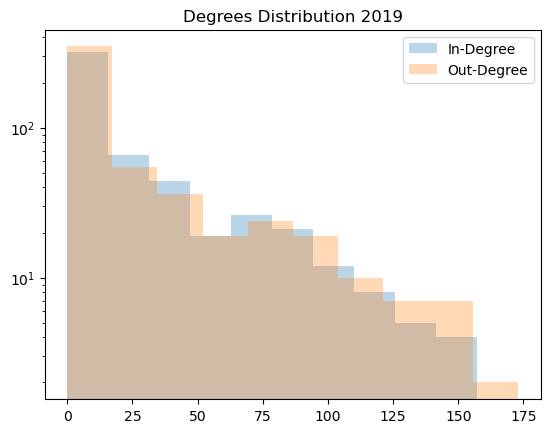

In [30]:
plt.hist(in_degree2019.values(),  alpha=0.3, log = True, label = 'In-Degree')
plt.hist(out_degree2019.values(),  alpha=0.3, log = True, label = 'Out-Degree')
plt.title('Degrees Distribution 2019')
plt.legend()

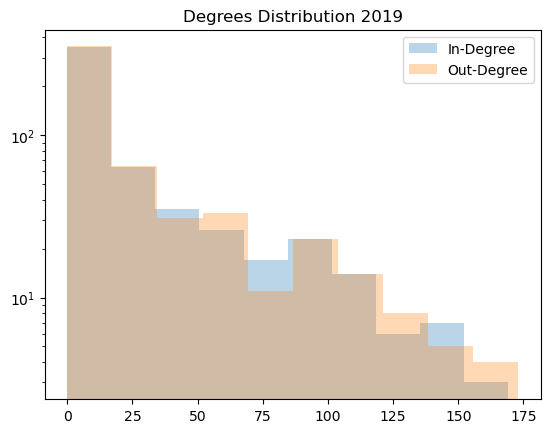

In [36]:
#caluculate in degrees 
in_degree2022 = dict(G2022_directed.in_degree)
out_degree2022 = dict(G2022_directed.out_degree)

plt.hist(in_degree2022.values(),  alpha=0.3, log = True, label = 'In-Degree')
plt.hist(out_degree2022.values(),  alpha=0.3, log = True, label = 'Out-Degree')
plt.title('Degrees Distribution 2019')
plt.legend()

In [39]:
#cannot confirm a powerlaw in degree distribution based on the p-value
in_degree2019_list = list(dict(in_degree2019).values())
fit = powerlaw.fit(in_degree2019_list)
a, loc, scale  = fit
kstest(in_degree2019_list, partial(powerlaw.cdf, a=a, loc=loc, scale=scale), alternative='two-sided')

KstestResult(statistic=0.22263641515895918, pvalue=4.074513645640479e-19)

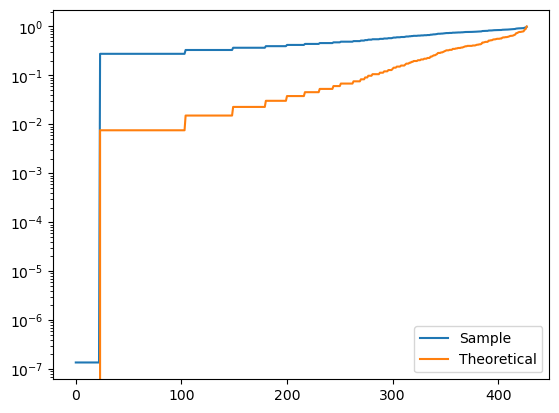

In [46]:
x_ = np.sort(powerlaw.cdf(in_degree2019_list, a=a, loc=loc, scale=scale))
x = np.sort(in_degree2019_list)/np.max(np.sort(in_degree2019_list))

plt.plot(x_, label = 'Sample')
plt.plot(x, label = 'Theoretical')
plt.yscale("log")
plt.legend()

## Strength

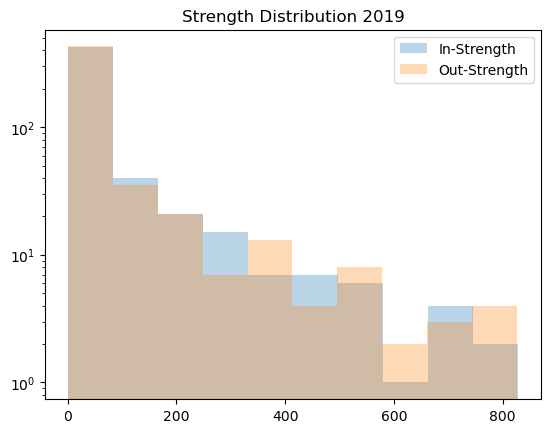

In [32]:
#strength distribution
in_strength2019 = dict(G2019_directed.in_degree(weight = 'weight'))
out_strength2019 = dict(G2019_directed.out_degree(weight = 'weight'))

plt.hist(in_strength2019.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
plt.hist(out_strength2019.values(), bins = 10, alpha=0.3, log = True, label = 'Out-Strength')
plt.title('Strength Distribution 2019')
plt.legend()


In [33]:
max_strength = max(out_strength2019, key=out_strength2019.get)
print(f"Max Out-Strength is at {max_strength} with {out_strength2019[max_strength]}.")

Max Out-Strength is at MUC with 827.


In [34]:
max_strength = max(in_strength2019, key=in_strength2019.get)
print(f"Max In-Strength is at {max_strength} with {in_strength2019[max_strength]}.")

Max In-Strength is at MUC with 829.


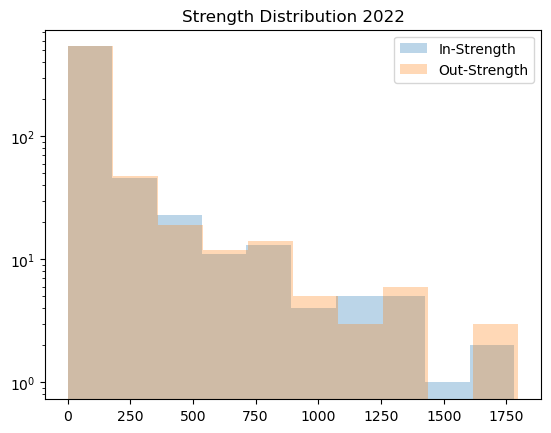

In [35]:
#strength distribution
in_strength2022 = dict(G2022_directed.in_degree(weight = 'weight'))
out_strength2022 = dict(G2022_directed.out_degree(weight = 'weight'))

plt.hist(in_strength2022.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
plt.hist(out_strength2022.values(), bins = 10, alpha=0.3, log = True, label = 'Out-Strength')
plt.title('Strength Distribution 2022')
plt.legend()


In [36]:
max_strength = max(out_strength2022, key=out_strength2022.get)
print(f"Max Out-Strength is at {max_strength} with {out_strength2022[max_strength]}.")

Max Out-Strength is at PMI with 1798.


In [37]:
max_strength = max(in_strength2022, key=in_strength2022.get)
print(f"Max In-Strength is at {max_strength} with {in_strength2022[max_strength]}.")

Max In-Strength is at PMI with 1781.


## Distance measures

In [38]:
from networkx.algorithms.distance_measures import diameter
from networkx import average_shortest_path_length

In [40]:
G2022_directed_connected.number_of_nodes()

571

In [41]:
#Calculate the diameter
diameter(G2019_directed_connected)

7

In [42]:
#Calculate the diameter
average_shortest_path_length(G2019_directed_connected)

2.477467354995445

## Centrality

In [41]:
centrality_measures = {"degree_centrality": nx.centrality.degree_centrality, #how connected the node is
                        "betweenness_centrality": nx.centrality.betweenness_centrality, #how important the node is in terms of connecting other nodes
                        "closeness_centrality": nx.centrality.closeness_centrality} #how easily a node can reach other nodes
centrality_values = pd.DataFrame()
for name, func in centrality_measures.items():
    for year in years:
        centr = pd.Series(func(G_directed_connected[year]))
        #Problem!!
        centrality_values = centrality_values.merge(centr.rename(name + " " + year), how = "outer", left_index= True, right_index=True)


In [48]:
centrality_values.loc["BER"]

degree_centrality 2019              NaN
degree_centrality 2022         0.556503
betweenness_centrality 2019         NaN
betweenness_centrality 2022    0.021166
closeness_centrality 2019           NaN
closeness_centrality 2022      0.551765
Name: BER, dtype: float64

In [36]:
airports[airports["city"] == "Berlin"]

,Unnamed: 0,airport_name,city,country,IATA,ICAO,latitude,longitude,continent
333,333,Berlin-Schönefeld Airport,Berlin,Germany,SXF,EDDB,52.3800,13.5225,EU
339,339,Berlin-Tempelhof International Airport,Berlin,Germany,THF,EDDI,52.4730,13.4039,EU
347,347,Berlin-Tegel Airport,Berlin,Germany,TXL,EDDT,52.5597,13.2877,EU


In [49]:
for year, G in G_directed_connected.items():
    print(year, ":", G.number_of_nodes())

2019 : 344
2022 : 470


# Density

In [16]:
for year in years:
    print(year, ": ", nx.density(G_directed[year]))

2019 :  0.04351156733568255
2022 :  0.044927244009812815


# BER Calculations

In [48]:
berlin_airports = {}
for year in years:
    berlin_airports[year] = [x for x in routes[year].origin_IATA.loc[routes[year]["origin_city"] == "Berlin"].unique()]

berlin_airports

{'2019': ['SXF', 'TXL'], '2022': ['BER', 'TXL']}

In [51]:
clustering = {}
for year in years:
    clustering[year] = nx.clustering(G_directed[year], berlin_airports[year])

clustering

{'2019': {'SXF': 0.3720659185775465, 'TXL': 0.45971278228458673},
 '2022': {'BER': 0.388972033923174, 'TXL': 0}}

In [52]:
for year in years:
    print(centrality_values[berlin_airports[year]])

NameError: name 'centrality_values' is not defined